In [1]:
# importing frameworks/packages that are required for the model to run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
#import torch
#from torch import nn, optim
#from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

<h1>C-MAPSS dataset Exploratory Data Analysis</h1>
The C-MAPSS dataset, a popular benchmark for evaluating the performance of various machine learning models, was employed to assess the efficacy of our proposed modules. This dataset comprises time-series data collected from 21 sensors, which monitor the degradation patterns of aircraft engines, as illustrated in Figure 6. The sensor data encompasses temperature, pressure, and speed measurements from diverse locations within the engine. The dataset is divided into four subsets: FD001, FD002, FD003, and FD004, with their specific characteristics outlined in our literature review. Notably from our initial exploratory data analysis, FD002 and FD004 are considered more intricate due to their larger number of training and testing trajectories, as well as their involvement in six distinct operational conditions.

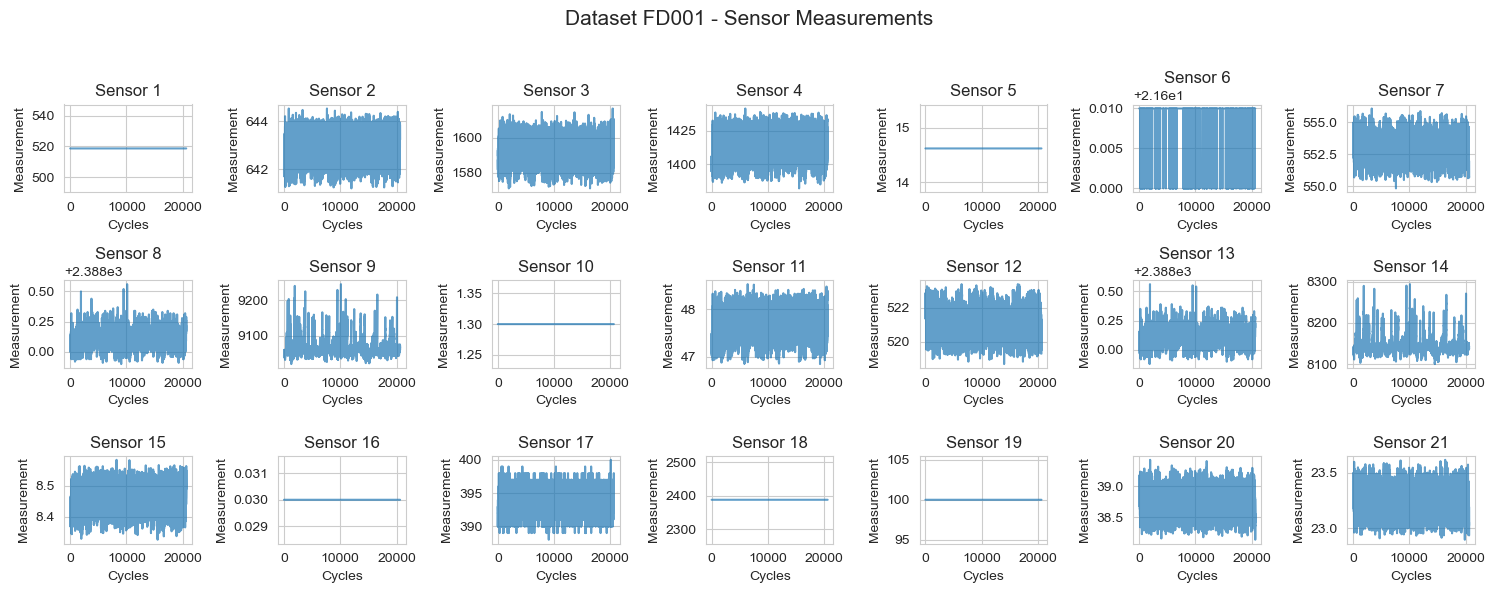

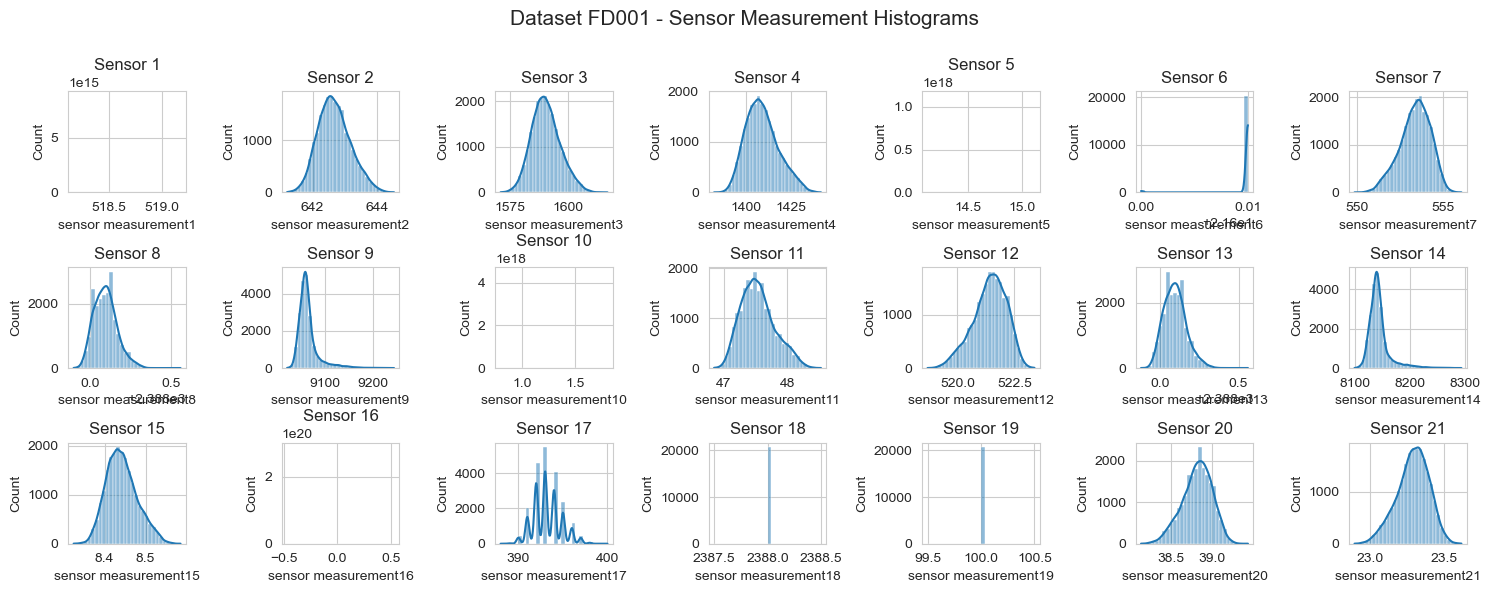

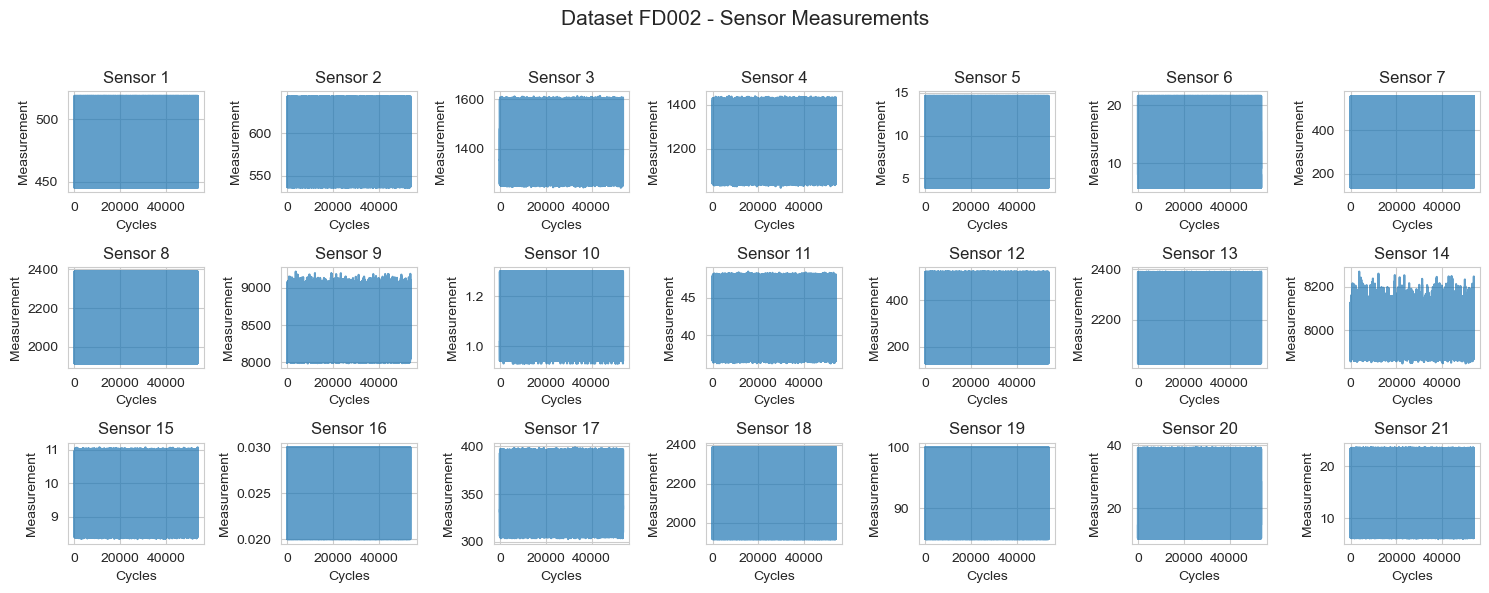

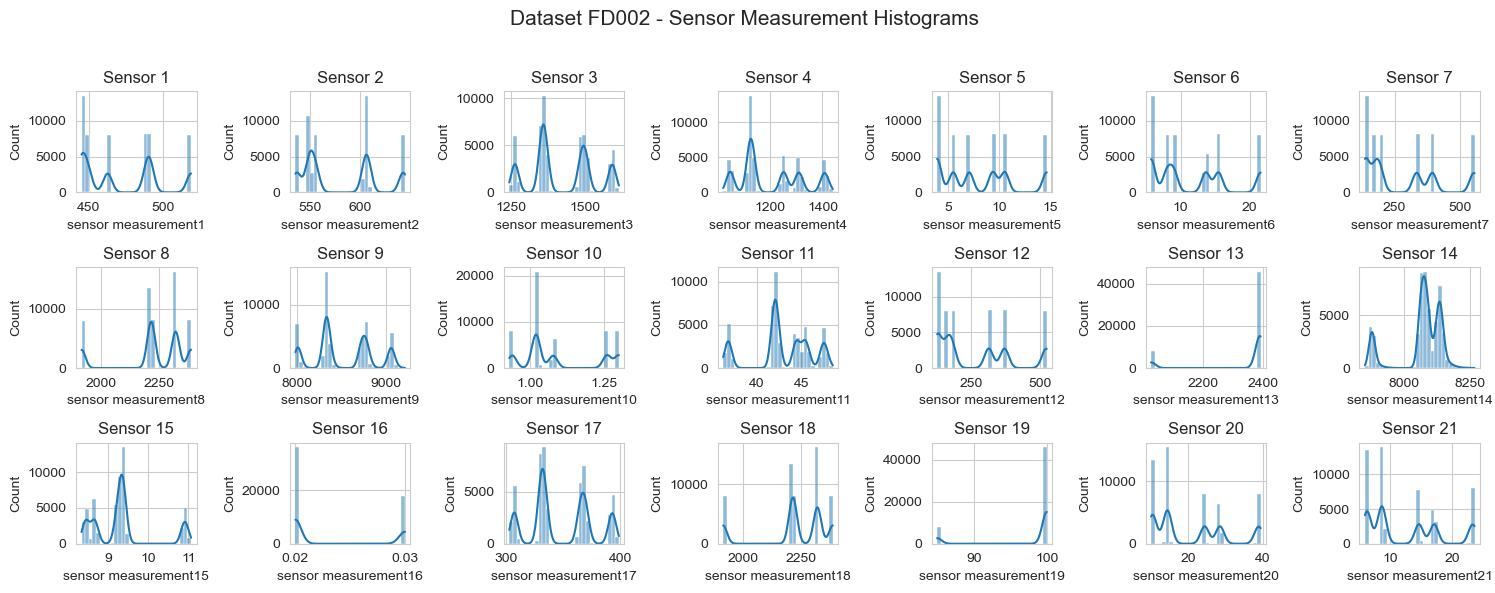

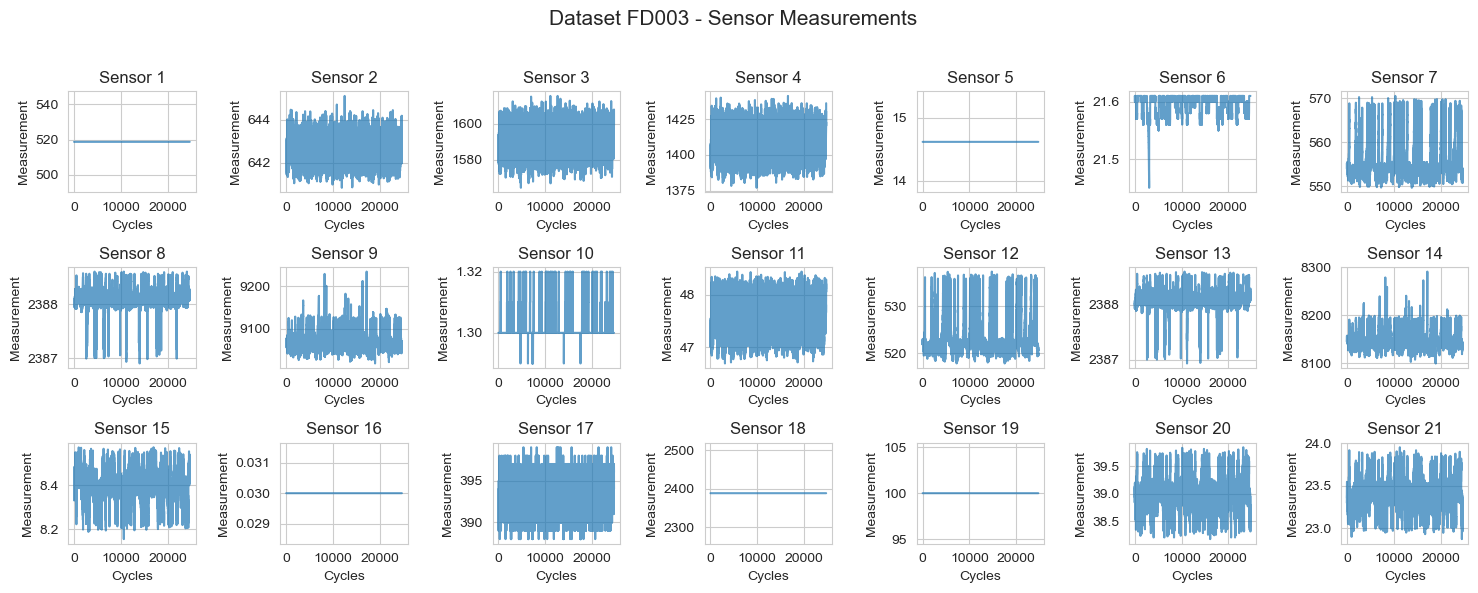

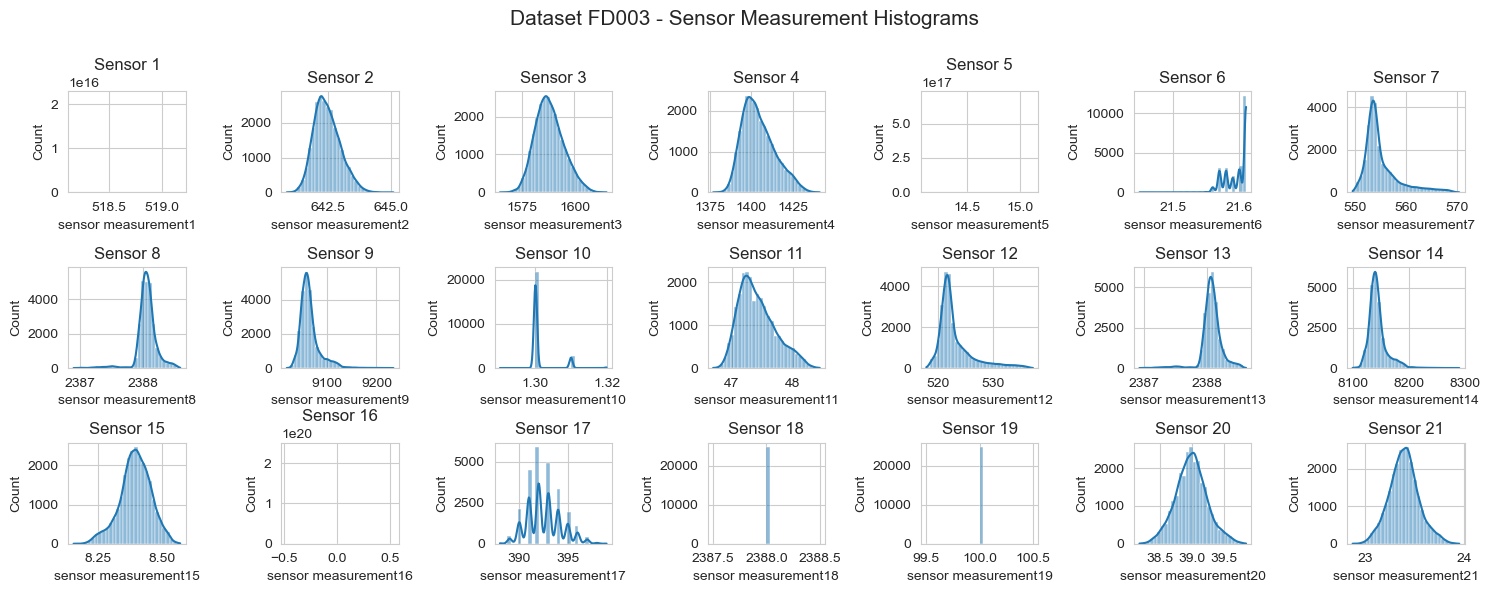

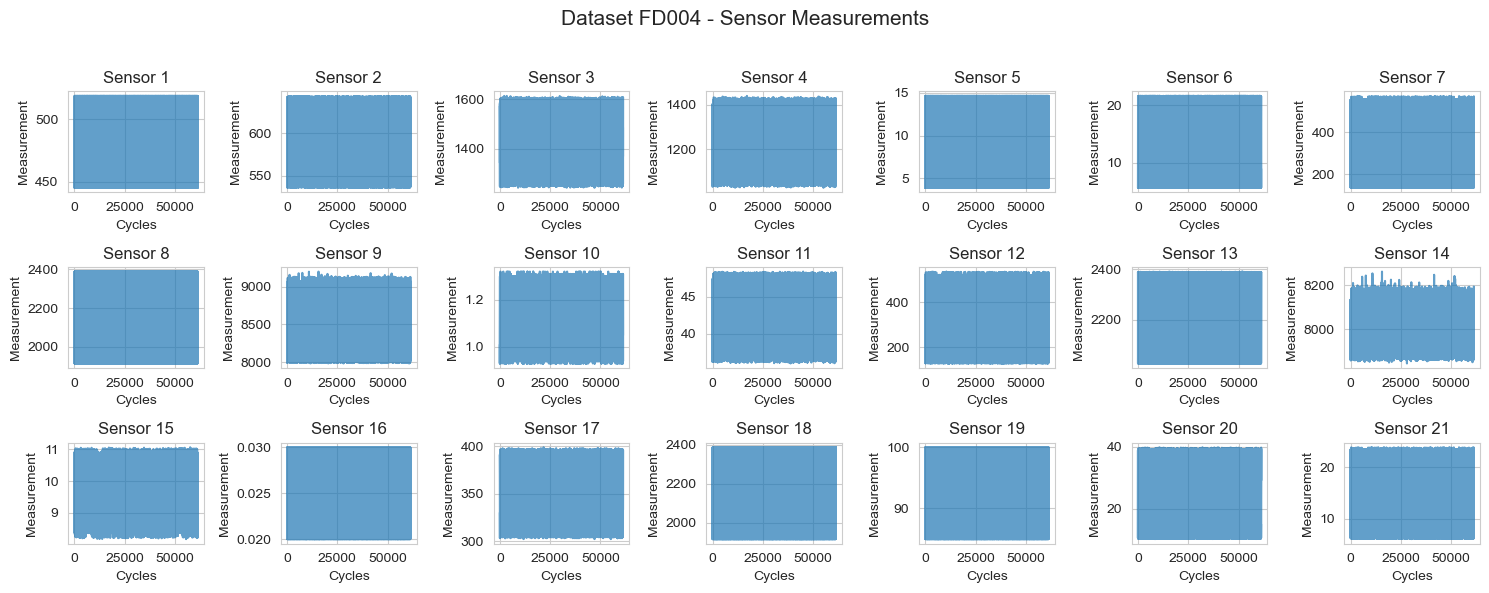

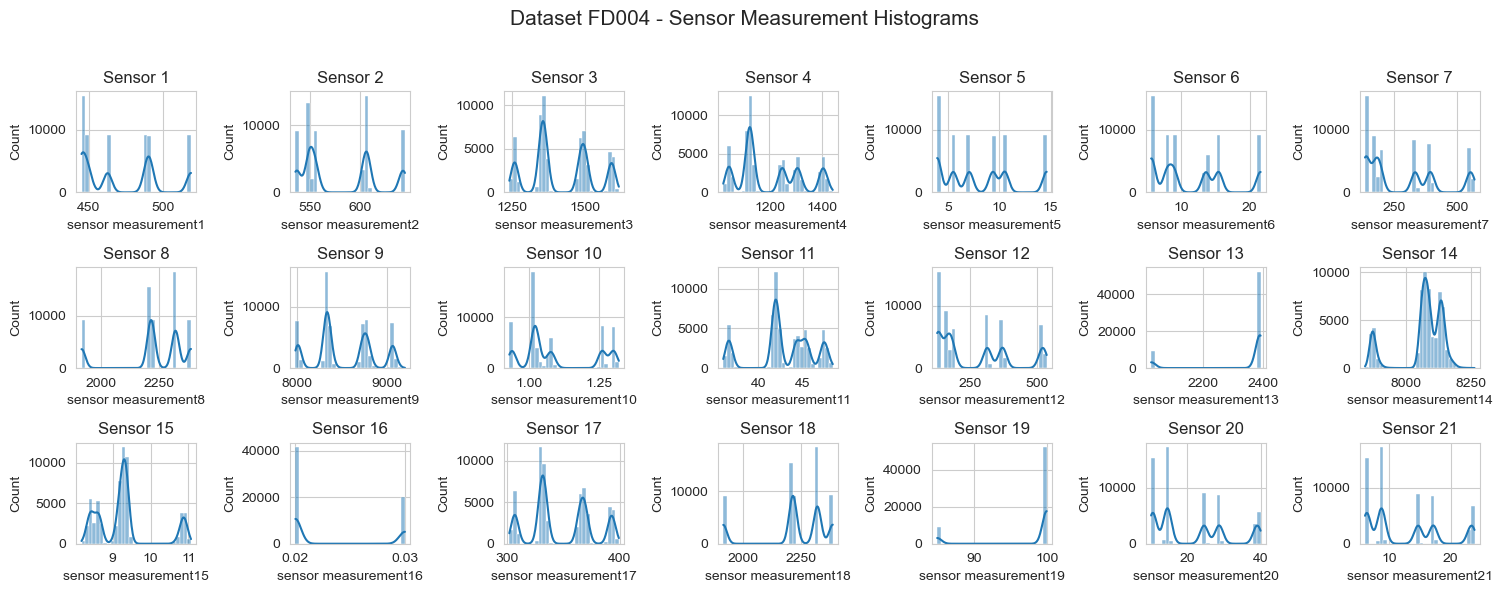

In [3]:
# Set the style for seaborn
sns.set_style("whitegrid")


def data_analysis_plot(j):
    # Load the dataset
    raw1 = np.loadtxt("./dataset/train_FD00" + str(j) + ".txt")
    df1 = pd.DataFrame(
        raw1,
        columns=[
            "unit",
            "cycles",
            "operational setting 1",
            "operational setting 2",
            "operational setting 3",
        ]
        + ["sensor measurement" + str(i) for i in range(1, 22)],
    )

    # Plot sensor measurement time series
    plt.figure(figsize=(15, 6))
    plt.suptitle("Dataset FD00" + str(j) + " - Sensor Measurements", fontsize=15)
    for i in range(1, 22):
        plt.subplot(3, 7, i)
        plt.title("Sensor " + str(i), fontsize=12)
        plt.plot(df1.iloc[:, i + 4], alpha=0.7)
        plt.xlabel("Cycles")
        plt.ylabel("Measurement")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plot histograms of sensor measurements
    plt.figure(figsize=(15, 6))
    plt.suptitle("Dataset FD00" + str(j) + " - Sensor Measurement Histograms", fontsize=15)
    for i in range(1, 22):
        plt.subplot(3, 7, i)
        plt.title("Sensor " + str(i), fontsize=12)
        sns.histplot(df1.iloc[:, i + 4], kde=True, bins=30)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == "__main__":
    # Iterate through datasets
    for dataset_number in range(1, 5):
        data_analysis_plot(dataset_number)

<h1>Exploratory Data Analysis on FD001</h1>

Data Preparation:

While the C-MAPSS dataset contains 21 sensors, certain sensors provide constant values, limiting their usefulness for our task. In line with previous research [8, 9], we eliminated these redundant sensors, focusing on the remaining 14. To process the time-series data, we employed a sliding window technique [5, 9, 37] with a window size of 30. For sequences shorter than 30, we padded them with the initial value. Data normalization is a crucial step in RUL prediction, and we adopted min-max normalization as suggested in [8]. To enhance the accuracy of RUL predictions, we incorporated piece-wise linear scaling for RUL values [38], capping the maximum RUL at 125.

<h2>Understanding the Piecewise Labeling</h2>

**Objective of Labeling:**

The goal is to create an RUL label for each cycle within a time window that reflects the number of cycles left before the unit fails. The RUL label decreases over time as the unit progresses through its lifecycle.

**Piecewise Label with a Cap:**

Instead of allowing RUL to decrease all the way to zero, the code applies a piecewise cap on the RUL values at 125 cycles. This means that any calculated RUL greater than 125 is set to 125.

**Why Cap the RUL?**

In practice, equipment degradation might not be linear. Beyond a certain point, the RUL values become less informative as they exceed a certain threshold.
Setting a cap at 125 helps standardize labels for cycles that are far from failure, which can make models easier to train and generalize. It reduces noise from high RUL values that may not have a strong predictive signal.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")


def load_and_clean_data(train_path, test_path, rul_path, columns, truth_columns):
    # Load datasets
    train_df = pd.read_csv(train_path, sep=" ", header=None)
    test_df = pd.read_csv(test_path, sep=" ", header=None)
    rul_df = pd.read_csv(rul_path, sep=" ", header=None)

    # Drop NaN columns and rename columns
    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)
    rul_df.dropna(axis=1, inplace=True)
    rul_df.insert(0, "unit_ID", range(1, len(rul_df) + 1))

    train_df.columns = columns
    test_df.columns = columns
    rul_df.columns = truth_columns

    return train_df, test_df, rul_df


def min_max_scale(df, sensor_indices):
    """Data Normalization: The min_max_scale function normalizes each sensor value using 
    min-max scaling, keeping the values between 0 and 1. This helps in piecewise scaling the data, 
    enhancing model performance and making it easier to detect underlying patterns."""
    for i in sensor_indices:
        min_val = df.iloc[:, i].min()
        max_val = df.iloc[:, i].max()
        df.iloc[:, i] = (df.iloc[:, i] - min_val) / (
            max_val - min_val + 1e-8
        )  # Avoid division by zero


def extract_labels_and_time_series(df, window_size=30, label_cap=125.0):
    units, values, labels = [], [], []

    for unit in df["unit_ID"].unique():
        unit_data = df[df["unit_ID"] == unit].copy()
        max_cycles = unit_data["cycles"].max()

        for i in range(len(unit_data)):
            # Cap RUL and add label
            """This line calculates the RUL as the difference between the maximum cycle count and the current cycle. 
            By using the min function with label_cap, any RUL values above label_cap are capped, creating a piecewise function. 
            Below this cap, the RUL is linear, and above it, it remains constant at label_cap.
            """
            label = min(max_cycles - unit_data.iloc[i]["cycles"], label_cap)
            labels.append(label)

            # Extract 30-cycle window, padding if needed
            """Sliding Window Approach: For each time step within a unit's operational history, 
            we capture a 30-cycle window, padded if there are fewer than 30 cycles available. 
            This approach allows for a more consistent input format across all units, 
            which is often required for machine learning models.
            """
            start = max(0, i - window_size + 1) 
            window = unit_data.iloc[
                start : i + 1, 2:-1
            ].values  # Exclude 'unit_ID' and 'cycles'
            if window.shape[0] < window_size:
                window = np.pad(
                    window, ((window_size - window.shape[0], 0), (0, 0)), "edge"
                )
            values.append(window.flatten())
            units.append(unit)

    return pd.DataFrame(values), units, labels


def plot_sensor_measurements(df, columns):
    fig, ax = plt.subplots(ncols=3, nrows=7, figsize=(24, 24))
    ax = ax.ravel()

    for i, sensor in enumerate(columns[5:]):  # Loop through sensor columns
        for j, unit in enumerate(df["unit_ID"].unique()):
            unit_data = df[df["unit_ID"] == unit]
            if j == 0:  # Add label only for the first unit to avoid duplication
                ax[i].plot(
                    unit_data["cycles"],
                    unit_data[sensor],
                    label=f"Unit {unit}",
                    alpha=0.75,
                )
            else:
                ax[i].plot(unit_data["cycles"], unit_data[sensor], alpha=0.75)

        ax[i].title.set_text(sensor)
        ax[i].legend().set_visible(
            False
        )  # Set to True only if you need individual legends

    plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)
    # Add a global legend outside the loop for the entire figure if needed
    fig.legend(
        df["unit_ID"].unique(),
        loc="upper right",
        title="Units",
        bbox_to_anchor=(1, 0.95),
    )
    plt.show()


if __name__ == "__main__":
    # Define file paths
    train_path = "./dataset/train_FD001.txt"
    test_path = "./dataset/test_FD001.txt"
    rul_path = "./dataset/RUL_FD001.txt"

    # Define column names
    columns = [
        "unit_ID",
        "cycles",
        "setting_1",
        "setting_2",
        "setting_3",
        "T2",
        "T24",
        "T30",
        "T50",
        "P2",
        "P15",
        "P30",
        "Nf",
        "Nc",
        "epr",
        "Ps30",
        "phi",
        "NRf",
        "NRc",
        "BPR",
        "farB",
        "htBleed",
        "Nf_dmd",
        "PCNfR_dmd",
        "W31",
        "W32",
    ]

    truth_columns = [
        "unit_ID",
        "RUL",
    ]

    # 1. Load and clean data
    train_df, test_df, rul_df = load_and_clean_data(
        train_path, test_path, rul_path, columns, truth_columns
    )

    # Check the shape of the DataFrames
    print("Train DataFrame shape:", train_df.shape)
    print("Test DataFrame shape:", test_df.shape)

    # 2. Data Visualization: Plotting sensor measurements to identify redundant sensor measurements
    plot_sensor_measurements(train_df, columns)

    # 3. Feature Selection: Remove redundant columns based on observations from sensor measurement plots
    columns_to_remove = ["T2", "P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
    train_df.drop(columns=columns_to_remove, inplace=True)
    test_df.drop(columns=columns_to_remove, inplace=True)

    # Check remaining columns after dropping
    print("Remaining columns in train_df:", train_df.columns)
    print("Remaining columns in test_df:", test_df.columns)

    # 4.Normalization: Normalize sensor data with min-max scaling
    # sensor_indices = range(5, len(train_df.columns))
    # min_max_scale(train_df, sensor_indices)
    # min_max_scale(test_df, sensor_indices)

    # 5. Label Extraction: Extract labels and time series data with 30-cycle windows
    """
    train_series:Each row corresponds to a 30-cycle sliding window of sensor measurements for a given unit and time point. 
    train_units:They provide a reference to which unit each row of time-series data corresponds.
    train_labels:These lists store the Remaining Useful Life (RUL) labels for each windowed row of data. 
    """
    train_series, train_units, train_labels = extract_labels_and_time_series(
        train_df, window_size=30
    )
    test_series, test_units, test_labels = extract_labels_and_time_series(
        test_df, window_size=30
    )

In [4]:
# Check unique units in train and test series
unique_train_units = set(train_units)
unique_test_units = set(test_units)

print("Unique Train Units:", unique_train_units)
print("Unique Test Units:", unique_test_units)

NameError: name 'train_units' is not defined

In [ ]:
train_series

In [ ]:
train_units

In [ ]:
train_labels

### **Throughout the process from here on, we will perform a series of transformations to the data. Ensure that the unit_ID column is preserved.**

Retaining the unit_ID (or any identifier for your data) is important for several reasons, especially when you want to perform testing and evaluation later in your analysis:

Importance of Retaining unit_ID
Mapping Predictions Back to Original Data: After making predictions with your model, you may need to map those predictions back to the original data points. Having the unit_ID allows you to link each prediction to the corresponding unit and understand the results better.

Evaluation of Model Performance: If you want to analyze how well your model performed for different units or groups, having the unit_ID lets you aggregate or segment performance metrics accordingly.

Data Visualization: When you visualize the results, such as plotting predicted vs. actual Remaining Useful Life (RUL), it’s helpful to know which predictions belong to which units for a clearer interpretation of the results.

Debugging and Analysis: If something goes wrong or if you see unexpected results, being able to trace back predictions to specific units helps in diagnosing issues.

<h3>RUL Calculation</h3>

**Training RUL Calculation:**
In the training dataset, each engine runs until failure, meaning we have data for every cycle up to the point of failure.
To create a target variable for training, the Remaining Useful Life (RUL) for each cycle in the training set is calculated and labelled using piecec-wise linear model. This gives a "countdown" of cycles until failure for each point in time in the training data, which is used as a label to teach the model.

**Testing RUL Calculation:**
The test dataset is different because it only shows the engine data until a certain point in time; each engine has a different last cycle, which is not necessarily its failure point.
The separate RUL_FD001.txt file gives the true RUL (in cycles) for each engine at the last cycle recorded in the test set. This is the RUL the model should predict for those specific last cycles in each test case.
Using these true RUL values as the target for the test set allows for an accurate evaluation of the model by comparing its predictions with the actual RUL values, which represent how many cycles remain before each engine will fail from the point it was last observed.

In [ ]:
# Create DataFrame for training series
train_df_final = pd.DataFrame(train_series)
train_df_final["unit_ID"] = train_units
train_df_final["RUL"] = train_labels

# Create DataFrame for testing series
test_df_final = pd.DataFrame(test_series)
test_df_final["unit_ID"] = test_units
test_df_final = test_df_final.merge(rul_df, on="unit_ID", how="left")
# Rename the RUL column to distinguish between predicted and true RUL if needed
test_df_final.rename(columns={"RUL": "true_RUL"}, inplace=True)

# Check the shape and head of the final DataFrames

"""quite different from the original dataset shape before processing. 
This is expected, as the number of features has changed significantly 
due to the sliding window approach you're using to create time series data."""

print("Final Training DataFrame shape:", train_df_final.shape)
print(train_df_final.head())

print("Final Testing DataFrame shape:", test_df_final.shape)
print(test_df_final.head())

The change in the shape of `train_df_final` to (20631, 482) is due to the transformation applied by the sliding window approach and the feature selection process. Here's a breakdown of why this happens:

1. **Sliding Window Approach**: 
   - You are using a 30-cycle sliding window to create time series data. This means for each unit, you are generating a new data point for every cycle after the first 29 cycles. This significantly increases the number of rows in your dataset because you are essentially creating a new feature vector for each cycle after the initial window size is reached.

2. **Feature Selection**:
   - After dropping the redundant columns, you have a reduced set of features. In your case, you removed 7 columns, leaving you with 19 sensor and setting columns (from the original 26 columns). 
   - Each window consists of 30 cycles, and for each cycle, you have these 19 features. Therefore, each row in your transformed dataset will have 30 * 19 = 570 features, plus the `unit_ID` and `RUL` columns, resulting in a total of 572 columns.

3. **Final DataFrame Construction**:
   - The `train_df_final` DataFrame is constructed by flattening each 30-cycle window into a single row. This results in a large number of columns (570 for the windowed features, plus 2 for `unit_ID` and `RUL`).
   - The number of rows (20631) corresponds to the total number of 30-cycle windows you can extract from your dataset across all units.

This transformation is expected when using a sliding window approach for time series data, as it allows you to capture temporal patterns over a fixed window size, which is crucial for many machine learning models that require fixed-size input vectors.